---
title: "Translating with LLMs"
subtitle: "Multilingual NLP -- Lab 5"
author: "Philippos Triantafyllou"
date: last-modified
date-format: long
lang: en
format:
    pdf:
        pdf-engine: lualatex
        documentclass: scrartcl
        fontsize: 16pt
        papersize: A3
        toccolor: blue
        classoption: 
            - "DIV=12"
            - "parskip=relative"
            - "titlepage=false"
        code-block-border-left: MediumBlue
        code-block-bg: WhiteSmoke
        template-partials:
            - "../_pandoc/doc-class.tex"
            - "../_pandoc/toc.tex"
            - "../_pandoc/before-title.tex"
toc: true
toc-depth: 3
number-depth: 1
number-sections: true
highlight-style: github
fig-cap-location: top
execute:
  echo: true
  output: true
embed-resources: true
---

## Constructing a small contextual test set

We load `Helsinki-NLP/opus_tedtalks`: it is a Croatian-English parallel corpus of transcribed and translated TED talks, originally extracted from https://wit3.fbk.eu. This corpus is sentence aligned for both language pairs.

In [1]:
from datasets import load_dataset

original_data = load_dataset("Helsinki-NLP/opus_tedtalks")
print(type(original_data))
print(original_data)


<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 86348
    })
})


We define a context window of 3 sentences before and after the target sentence. We randomly sample 20 sentences from the training set, with its context window.

In [2]:
import random
from datasets import Dataset

train: Dataset = original_data['train'] # type: ignore
translations = train["translation"]
n = len(translations)

valid_indices = list(range(3, n - 3))
random.seed(42)
sampled_indices = random.sample(valid_indices, k=20)

We a small test set of 20 examples structured as follows:

- source: the English sentence to be translated;
- translation: the Croatian translation of the source sentence, we will use this as reference to compute COMET scores later on;
- context: the context window of 3 sentences before and after the source sentence. We have both English and Croatian context.

We unfortunately have to reduce the size of the test set due to Ollama getting stuck at processing larger amounts of data. We started with 100 examples but we found that beyond 20 examples, model's would simply stop working...

In [3]:
examples = []

for i in sampled_indices:
    center = translations[i]

    window = {
        "source": center["en"],
        "reference": center["hr"],
        "context_before": [
            translations[i - 3],
            translations[i - 2],
            translations[i - 1],
        ],
        "context_after": [
            translations[i + 1],
            translations[i + 2],
            translations[i + 3],
        ],
    }

    examples.append(window)

In [5]:
#| echo: false

for i, ex in enumerate(examples[:3]):
    print(f"Example {i+1}:")
    print(f"Source: {ex['source']}")
    print(f"Reference: {ex['reference']}")
    print("Context before:")
    for ctx in ex["context_before"]:
        print(f" - {ctx['en']}")
    print("Context after:")
    for ctx in ex["context_after"]:
        print(f" - {ctx['en']}")
    print()

print(f"...and so on for a total of {len(examples)} examples.")

Example 1:
Source: (Laughter) Idiot, Robbins.
Reference: (Smijeh) Idiote, Robbins.
Context before:
 - The defining factor is never resources; it's resourcefulness.
 - And what I mean specifically, rather than just some phrase, is if you have emotion, human emotion, something that I experienced from you a day before yesterday at a level that is as profound as I've ever experienced, and if you'd communicated with that emotion I believe you would have beat his ass and won.
 - (Applause) But, how easy for me to tell him what he should do.
Context after:
 - But I know when we watched the debate at that time, there were emotions that blocked people's ability to get this man's intellect and capacity.
 - And the way that it came across to some people on that day -- because I know people that wanted to vote in your direction and didn't, and I was upset.
 - But there was emotion that was there.

Example 2:
Source: We all know everybody in this room makes mistakes.
Reference: Svi mi znamo da svat

There were no datasets online (that we found at least) that had timestamps, and many datasets did not have sentence level gold translations, so it was difficult to create proper examples. For example, we tried loading a English-Spanish dataset from TED talks, but the translations were only at the talk level, not sentence level. We tried segmenting the talks into sentences and then aligning them, but it was a failure. Although we do not understand Croatian, we have the correct setup to compute COMET scores later on, that we can interpret. Furthermore, the great advantage of this dataset is that the pairs are aligned at the talk level so constructing context windows is straightforward. Choosing 20 examples was a trade-off between having enough examples to compute meaningful COMET scores later on, and the time for one Ollama call. Since for each example we are trying many configurations, this can take a while. For that reason, we set up Ollama to run on GPU, considerably speeding up inference time.

## Set up Ollama LLM environment

Everything is run on Google Colab with a A100 GPU.

Loads ollama (needs to be installed).

In [ ]:
#| eval: false

!pip -q install ollama
!sudo apt update
!sudo apt install -y pciutils
!sudo apt-get install zstd
!curl -fsSL https://ollama.com/install.sh | sh

In [ ]:
#| output: false

import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)

Error: listen tcp 127.0.0.1:11434: bind: address already in use


In [ ]:
#| eval: false

!ollama pull llama3.2
!ollama pull mistral

We try with two models: `llama3.2` and `mistral`.

In [7]:
MODELS = ["llama3.2", "mistral"]

Here we simply set up our main Ollama call function, it is prompt and model agnostic, so we can reuse it later on.

In [8]:
SYSTEM_PROMPT = "You are a you are an expert translator that translates English text to Croatian."
USER_PROMPT = "Translate the following English text to Croatian: 'We all know everybody in this room makes mistakes.'"

We will use json schemas to structure the output of our LLM calls. One of the major hassles of prompting LLMs is to get them to output in a structured way, instead of writing huge prompts giving convoluted instructions and adapting to each edge case when the model fails, we simply use json schemas to define the output structure we want. Ollama supports this natively, it never (well...) fails.

In [9]:
from pydantic import BaseModel

class TranslationSchema(BaseModel):
    translation: str

The function takes a model, a system prompt, a user prompt, and a schema to structure the output. It simply returns the parsed output according to the schema. We will wrap this function to create more specific outputs for evaluation. We set temperature to 0.

We specify `num_predict` as sometimes the model (especially mistral) can get stuck in an infinite generation loop. This is the case for the COT experiments especially because the model is trying to "think" while having to generate the very strict json schema we have defined. This argument here ensures that the model will stop generating after a certain number of tokens. We specify a large enough number so that when we predict 5 candidate translations, the model has enough tokens to generate all of them.

In [10]:
from typing import Type, TypeVar, Any
import ollama

T = TypeVar("T", bound=TranslationSchema)

def call_ollama(*, model: str, system_prompt: str, user_prompt: str, schema: Type[T]) -> T:
    # Convert schema to JSON Schema
    json_schema: dict[str, Any] = schema.model_json_schema()
    json_schema["additionalProperties"] = False

    # Ollama chat call with schema-constrained decoding
    response = ollama.chat(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        format=json_schema,
        stream=False,
        options={
            "temperature": 0.0,
            "num_predict": 512,
        },
    )

    # Extract and validate
    content: str = response["message"]["content"]
    output = schema.model_validate_json(content)

    return output

One response takes around 3 seconds (on CPU it was around 15-20 seconds), so for 100 examples and many configurations this can take a while... and it fails... we will stick to 20 examples.

In [11]:
result = call_ollama(model=MODELS[0], system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT, schema=TranslationSchema)
print(result)

translation='Sve se zna da svaki u ovom salju napravljaju greške.'


Finally, we define a function that is our pipeline to run translations with different strategies (direct, COT, $n$-shot). It takes the examples, model, output path, strategy name, prompt builder function, and schema to structure the output. It writes the results to a file in JSONL format.

In [12]:
import json
from tqdm import tqdm
from typing import Callable

def run_translation(
    *,
    examples: list[dict],
    model: str,
    output_path: str,
    strategy: str,
    prompt_builder: Callable[[dict, bool], str],
    schema: Type[T] = TranslationSchema,
    extract: Callable[[T], Any]
) -> None:

    with open(output_path, "w", encoding="utf-8") as f:
        for example_id, ex in enumerate(tqdm(examples, desc=f"{strategy} translation")):
            translations = {}

            for use_context in (False, True):
                user_prompt = prompt_builder(ex, use_context)

                try:
                    parsed = call_ollama(
                        model=model,
                        system_prompt=SYSTEM_PROMPT,
                        user_prompt=user_prompt,
                        schema=schema,
                    )

                    key = "with_context" if use_context else "no_context"
                    translations[key] = extract(parsed)

                except Exception:
                    key = "with_context" if use_context else "no_context"
                    translations[key] = "ERROR"

            record = {
                "example_id": example_id,
                "model": model,
                "strategy": strategy,
                "source": ex["source"],
                "translations": translations,
            }

            f.write(json.dumps(record, ensure_ascii=False) + "\n")

## Experiments

### Direct translation prompt

The direct translation prompt schema is simple, we just want the translation of the source sentence.

In [13]:
class DirectTranslation(TranslationSchema):
    translation: str

We first design the prompt template. For each example we specify if we want context or not. Otherwise the prompt is straightforward.

In [14]:
def build_direct_prompt(example: dict, use_context: bool = False) -> str:
    if use_context:
        context_lines = []

        for c in example.get("context_before", []):
            context_lines.append(f"- {c['en']}")

        for c in example.get("context_after", []):
            context_lines.append(f"- {c['en']}")

        context_block = "\n".join(context_lines)

        prompt = (
            "Translate the following sentence into Croatian.\n\n"
            "Context:\n"
            f"{context_block}\n\n"
            "Sentence to translate:\n"
            f"{example['source']}"
        )
    else:
        prompt = (
            "Translate the following sentence into Croatian.\n\n"
            f"{example['source']}"
        )

    return prompt

Let's try.

In [ ]:
#| eval: false

run_translation(
    examples=examples,
    model=MODELS[0],
    output_path=f"direct_translations_{MODELS[0]}.jsonl",
    strategy="direct",
    prompt_builder=build_direct_prompt,
    schema=DirectTranslation,
    extract=lambda x: x.translation
)

In [ ]:
#| eval: false

run_translation(
    examples=examples,
    model=MODELS[1],
    output_path=f"direct_translations_{MODELS[1]}.jsonl",
    strategy="direct",
    prompt_builder=build_direct_prompt,
    schema=DirectTranslation,
    extract=lambda x: x.translation
)

### Chain-of-thought translation prompt

In [15]:
class COTTranslation(TranslationSchema):
    translation: str

We still define a simple json schema where the only thing that we care about is the final translation. Indeed, we could be tempted to also store the intermediate steps of the reasoning, but our experience (especially in the agents class) has shown that the more "thinking" steps we ask the model to generate, the more likely it is to make mistakes or hallucinate data just to fill in the blanks. This is important in our case, since we use small models that have not been designed to "reason" per se.

Therefore in our prompt we specify the reasoning steps with the magic words "think step by step", but we only ask the model to output the final translation. We also keep the thinking steps to the minimum, as it is also a factor of confusion more than anything else for such small models. The jey element in the prompt here is the "think step by step" phrase.

In [16]:
def build_cot_prompt(example: dict, use_context: bool = False) -> str:
    if use_context:
        context_lines = []

        for c in example.get("context_before", []):
            context_lines.append(f"- {c['en']}")

        for c in example.get("context_after", []):
            context_lines.append(f"- {c['en']}")

        context_block = "\n".join(context_lines)

        prompt = (
            "Translate the following sentence into Croatian. Think step-by-step.\n\n"
            "Step 1: Identify potential translation difficulties.\n"
            "Step 2: Produce a context-aware translation.\n"
            "Step 3: Revise the translation to correct any errors.\n\n"
            "Context:\n"
            f"{context_block}\n\n"
            "Sentence to translate:\n"
            f"{example['source']}"
        )
    else:
        prompt = (
            "Translate the following sentence into Croatian. Think step-by-step.\n\n"
            "Step 1: Identify potential translation difficulties.\n"
            "Step 2: Produce a translation.\n"
            "Step 3: Revise the translation to correct any errors.\n\n"
            "Sentence to translate:\n"
            f"{example['source']}"
        )

    return prompt

In [ ]:
#| eval: false
#| output: false

run_translation(
    examples=examples,
    model=MODELS[0],
    output_path=f"cot_translations_{MODELS[0]}.jsonl",
    strategy="cot",
    prompt_builder=build_cot_prompt,
    schema=COTTranslation,
    extract=lambda x: x.translation
)

In [ ]:
#| eval: false
#| output: false

run_translation(
    examples=examples,
    model=MODELS[1],
    output_path=f"cot_translations_{MODELS[1]}.jsonl",
    strategy="cot",
    prompt_builder=build_cot_prompt,
    schema=COTTranslation,
    extract=lambda x: x.translation
)

### $n$-best generation prompt

We no longer ask for a single translation but for $n$ candidate translations. The schema is modified accordingly.

In [17]:
class NBestTranslation(TranslationSchema):
    candidates: list[str]

The prompt is a slight modification of the direct prompt, we just specify that we want $n$ candidate translations. We also specify that the translations should be diverse, in order to encourage the model to explore different possibilities. We set $n=5$ for our experiments.

In [18]:
def build_nbest_prompt(example: dict, use_context: bool = False, n: int = 5) -> str:
    if use_context:
        context_lines = []

        for c in example.get("context_before", []):
            context_lines.append(f"- {c['en']}")

        for c in example.get("context_after", []):
            context_lines.append(f"- {c['en']}")

        context_block = "\n".join(context_lines)

        prompt = (
            f"Translate the following sentence into Croatian.\n\n"
            f"Generate {n} distinct candidate translations.\n"
            "They should differ in wording or structure, but all be valid.\n\n"
            "Context:\n"
            f"{context_block}\n\n"
            "Sentence to translate:\n"
            f"{example['source']}"
        )
    else:
        prompt = (
            f"Translate the following sentence into Croatian.\n\n"
            f"Generate {n} distinct candidate translations.\n"
            "They should differ in wording or structure, but all be valid.\n\n"
            f"{example['source']}"
        )

    return prompt

In [ ]:
#| eval: false
#| output: false

run_translation(
    examples=examples,
    model=MODELS[0],
    output_path=f"nbest_translations_{MODELS[0]}.jsonl",
    strategy="nbest",
    prompt_builder=build_nbest_prompt,
    schema=NBestTranslation,
    extract=lambda x: x.candidates
)

In [ ]:
#| eval: false
#| output: false

run_translation(
    examples=examples,
    model=MODELS[1],
    output_path=f"nbest_translations_{MODELS[1]}.jsonl",
    strategy="nbest",
    prompt_builder=build_nbest_prompt,
    schema=NBestTranslation,
    extract=lambda x: x.candidates
)

## Evaluation with COMET

### Loading results

In [98]:
import os
import json

def load_results(dir_path):
    llama = {}
    mistral = {}

    for filename in os.listdir(dir_path):
        if not filename.endswith(".jsonl"):
            continue

        path = os.path.join(dir_path, filename)

        records = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                records.append(json.loads(line))

        name = filename.lower()

        # model
        if "llama" in name:
            model_dict = llama
        elif "mistral" in name:
            model_dict = mistral
        else:
            continue

        # strategy
        if name.startswith("direct_"):
            strategy = "direct"
        elif name.startswith("cot_"):
            strategy = "cot"
        elif name.startswith("nbest_"):
            strategy = "nbest"
        else:
            continue

        model_dict[strategy] = records

    return llama, mistral

In [99]:
llama_results, mistral_results = load_results("data")

We inject the reference translations into each of the results for easier evaluation later on.

In [100]:
def inject_references(model_data, examples):
    updated = {}

    for strategy, records in model_data.items():
        new_records = []

        for r in records:
            example_id = r["example_id"]
            reference = examples[example_id]["reference"]

            new_r = {
                "example_id": example_id,
                "model": r["model"],
                "strategy": r["strategy"],
                "source": r["source"],
                "reference": reference,
                "translations": r["translations"],
            }

            new_records.append(new_r)
        
        updated[strategy] = new_records

    return updated

In [101]:
llama_results = inject_references(llama_results, examples)
mistral_results = inject_references(mistral_results, examples)

In [102]:
#| echo: false

def print_example(model_data: dict, model_name: str, i: int) -> None:
    record0 = model_data["direct"][i]

    print(f"{model_name} -- example {record0['example_id']}")
    print(f"SRC: {record0['source']}")
    print(f"REF: {record0.get('reference', 'MISSING')}")

    for strategy, records in model_data.items():
        r = records[i]
        print(f"{strategy}:")

        for ctx, val in r["translations"].items():
            if isinstance(val, list):
                print(f"  {ctx}:")
                for j, v in enumerate(val, 1):
                    print(f"    {j}) {v}")
            else:
                print(f"  {ctx}: {val}")

We can view one example for mistral. Although for most examples the models have correctly output translations (we are not talking about translation quality here only that the pipeline worked), we can see that it some cases it has failed to do so. These cases are rare though.

It is very difficult to figure out why the model fails at this example, with that specific setup. We see for example that the model fails only when context is provided. Is it because there is a long context? No because there are longer examples that have been parsed fine. We have a hint of an explanation for the failure at the COT prompt, as mistral was particularly sensitive at this experiment, and constantly was getting suck at generation loops. Perhaps it is the case also here...

In [105]:
#| echo: false

print_example(mistral_results, "mistral", 1)

mistral -- example 1
SRC: We all know everybody in this room makes mistakes.
REF: Svi mi znamo da svatko od nas u ovoj sobi čini pogreške.
nbest:
  no_context:
    1) Svaka osoba u ovoj sobi može napraviti grešku.
    2) U ovoj sobi se svi ljudi mogu pogrešiti.
    3) Svi poznajemo da svatko u ovoj sobi može napraviti pogrešku.
    4) Svaka osoba u ovoj sobi ima tendenciju da pogreši.
    5) U ovoj sobi se sva osoba može pogrešiti, ako bi se pogrešila.
  with_context: ERROR
cot:
  no_context: Svi poznati smo sve one u ovoj sobi pogrešuju. (formal)
  with_context: ERROR
direct:
  no_context: Svi poznajemo da svaki u ovoj sobi pogreškuje. (formal)
  with_context: Svi poznajemo da svaki u ovoj sobi pogreškuje. (Laughter)


### Loading COMET

In [ ]:
#| eval: false

!pip install unbabel-comet

We load a pre-trained COMET model.

In [ ]:
#| output: false

from comet import download_model, load_from_checkpoint

model_path = download_model("Unbabel/wmt22-comet-da")
comet_model = load_from_checkpoint(model_path)

### Compute scores for direct and COT translations

First we format the results as a pandas DataFrame for easier processing.

In [107]:
import pandas as pd

def format_results(model_results):
    rows = []

    direct_records = {r["example_id"]: r for r in model_results["direct"]}
    cot_records = {r["example_id"]: r for r in model_results["cot"]}

    example_ids = sorted(direct_records.keys())

    for example_id in example_ids:
        direct_record = direct_records[example_id]
        cot_record = cot_records[example_id]

        model_name = direct_record["model"]
        source_sentence = direct_record["source"]
        reference_translation = direct_record["reference"]

        for context_key, use_context in [("no_context", False), ("with_context", True)]:
            direct_translation = direct_record["translations"].get(context_key)
            cot_translation = cot_record["translations"].get(context_key)

            rows.append({
                "example_id": example_id,
                "model": model_name,
                "use_context": use_context,
                "source": source_sentence,
                "reference": reference_translation,
                "direct_translation": (
                    direct_translation if direct_translation != "ERROR" else None
                ),
                "cot_translation": (
                    cot_translation if cot_translation != "ERROR" else None
                ),
            })

    return pd.DataFrame(rows)

In [108]:
df_llama = format_results(llama_results)
df_mistral = format_results(mistral_results)

display(df_mistral.head())
display(df_llama.head())

,example_id,model,use_context,source,reference,direct_translation,cot_translation
0,0,mistral,False,"(Laughter) Idiot, Robbins.","(Smijeh) Idiote, Robbins.","(Smeh) Glupavac, Robbins.","Humor: Idiot, Robbins."
1,0,mistral,True,"(Laughter) Idiot, Robbins.","(Smijeh) Idiote, Robbins.","Zabava (smijeh). Gubitnik, Robbins.","Zabavljenje! Moron, Robbins."
2,1,mistral,False,We all know everybody in this room makes mista...,Svi mi znamo da svatko od nas u ovoj sobi čini...,Svi poznajemo da svaki u ovoj sobi pogreškuje....,Svi poznati smo sve one u ovoj sobi pogrešuju....
3,1,mistral,True,We all know everybody in this room makes mista...,Svi mi znamo da svatko od nas u ovoj sobi čini...,Svi poznajemo da svaki u ovoj sobi pogreškuje....,None
4,2,mistral,False,One man died after working a 36-hour shift.,Jedan je čovjek umro nakon rada u 36-osatnoj s...,Jedan čovjek umro nakon što je radio 36 sati n...,Jedan čovjek umro nakon što je radio 36 sati n...


,example_id,model,use_context,source,reference,direct_translation,cot_translation
0,0,llama3.2,False,"(Laughter) Idiot, Robbins.","(Smijeh) Idiote, Robbins.",Smešanje,Smešanje
1,0,llama3.2,True,"(Laughter) Idiot, Robbins.","(Smijeh) Idiote, Robbins.","Hahahaha, idiot, Robbins.","Hahahaha, idiot, Robbins."
2,1,llama3.2,False,We all know everybody in this room makes mista...,Svi mi znamo da svatko od nas u ovoj sobi čini...,Svi mi znaju da sve ljudi u ovom salju naporne...,Sve ljudi u ovom sali znaju da svaki jedan čin...
3,1,llama3.2,True,We all know everybody in this room makes mista...,Svi mi znamo da svatko od nas u ovoj sobi čini...,Sve se zna da svaki u ovom salju napravljaju g...,Sve se zna da svaki u ovom salju napravljaju g...
4,2,llama3.2,False,One man died after working a 36-hour shift.,Jedan je čovjek umro nakon rada u 36-osatnoj s...,Jedan muškarac je umro poslije radnog perioda...,Jedan muškarac je umro poslije radnog perioda...


Then we can compute COMET scores for each of the configurations.

In [109]:
import numpy as np

def compute_comet_scores(df, comet_model, batch_size=32):
    df = df.copy()

    direct_inputs = (
        df[["source", "direct_translation", "reference"]]
        .dropna()
        .rename(columns={
            "source": "src",
            "direct_translation": "mt",
            "reference": "ref",
        })
        .to_dict(orient="records")
    )

    cot_inputs = (
        df[["source", "cot_translation", "reference"]]
        .dropna()
        .rename(columns={
            "source": "src",
            "cot_translation": "mt",
            "reference": "ref",
        })
        .to_dict(orient="records")
    )

    direct_scores = comet_model.predict(
        direct_inputs,
        batch_size=batch_size,
        devices=None,
    )["scores"]

    cot_scores = comet_model.predict(
        cot_inputs,
        batch_size=batch_size,
        devices=None,
    )["scores"]

    df["direct_comet"] = np.nan
    df["cot_comet"] = np.nan

    df.loc[df["direct_translation"].notna(), "direct_comet"] = direct_scores
    df.loc[df["cot_translation"].notna(), "cot_comet"] = cot_scores

    return df[
        ["example_id", "model", "use_context", "direct_comet", "cot_comet"]
    ]

In [ ]:
#| include: false
#| eval: false

df_llama_scores = compute_comet_scores(df_llama, comet_model)
df_mistral_scores = compute_comet_scores(df_mistral, comet_model)

In [ ]:
#| echo: false

display(df_mistral_scores.head())
display(df_llama_scores.head())

,example_id,model,use_context,direct_comet,cot_comet
0,0,mistral,False,0.553233,0.689814
1,0,mistral,True,0.495465,0.632318
2,1,mistral,False,0.780109,0.446424
3,1,mistral,True,0.777017,NaN
4,2,mistral,False,0.857379,0.857379


,example_id,model,use_context,direct_comet,cot_comet
0,0,llama3.2,False,0.522337,0.522337
1,0,llama3.2,True,0.801935,0.801935
2,1,llama3.2,False,0.377261,0.786811
3,1,llama3.2,True,0.711428,0.711428
4,2,llama3.2,False,0.913990,0.913990


### Compute COMET scores for $n$-shot translations

We can do the same for the $n$-best translations.

In [117]:
def format_results2(model_results):
    rows = []

    nbest_records = model_results["nbest"]

    for nbest_record in nbest_records:
        example_id = nbest_record["example_id"]
        model_name = nbest_record["model"]
        source_sentence = nbest_record["source"]
        reference_translation = nbest_record["reference"]

        for context_key, use_context in [("no_context", False), ("with_context", True)]:
            candidate_translations = nbest_record["translations"].get(context_key)

            rows.append({
                "example_id": example_id,
                "model": model_name,
                "use_context": use_context,
                "source": source_sentence,
                "reference": reference_translation,
                "candidates": (
                    candidate_translations
                    if isinstance(candidate_translations, list)
                    else None
                ),
            })

    return pd.DataFrame(rows)

In [119]:
df_llama_nbest = format_results2(llama_results)
df_mistral_nbest = format_results2(mistral_results)

And we compute COMET scores for each of the configurations. For each example, we take the best COMET score among the $n$ candidates as the final score for that example with `np.max(scores)`.

In [120]:
def compute_comet_scores_nbest(df, comet_model, batch_size=32):
    df = df.copy()
    df["nbest_best_score"] = np.nan

    for row_index in df.index:
        candidate_list = df.at[row_index, "candidates"]

        if not isinstance(candidate_list, list) or len(candidate_list) == 0:
            continue

        comet_inputs = [
            {
                "src": df.at[row_index, "source"],
                "mt": candidate,
                "ref": df.at[row_index, "reference"],
            }
            for candidate in candidate_list
        ]

        try:
            scores = comet_model.predict(
                comet_inputs,
                batch_size=batch_size,
                devices=None,
            )["scores"]
            df.at[row_index, "nbest_best_score"] = float(np.max(scores))

        except Exception:
            df.at[row_index, "nbest_best_score"] = np.nan

    return df[
        ["example_id", "model", "use_context", "nbest_best_score"]
    ]

In [ ]:
#| include: false
#| eval: false

df_llama_scores_nbest = compute_comet_scores_nbest(df_llama_nbest, comet_model)
df_mistral_scores_nbest = compute_comet_scores_nbest(df_mistral_nbest, comet_model)

In [ ]:
#| echo: false

display(df_llama_scores_nbest.head())
display(df_mistral_scores_nbest.head())

,example_id,model,use_context,nbest_best_score
0,0,llama3.2,False,0.845271
1,0,llama3.2,True,0.769413
2,1,llama3.2,False,0.711428
3,1,llama3.2,True,0.864808
4,2,llama3.2,False,0.913262


,example_id,model,use_context,nbest_best_score
0,0,mistral,False,0.701950
1,0,mistral,True,0.817929
2,1,mistral,False,0.915458
3,1,mistral,True,NaN
4,2,mistral,False,0.883250


---

We merge.

In [ ]:
def merge_comet_tables(direct_df, cot_df, nbest_df):
    direct_df = direct_df.rename(columns={ "comet_score": "direct_comet_score" })
    cot_df = cot_df.rename(columns={ "comet_score": "cot_comet_score" })

    # Merge direct and CoT
    merged_df = pd.merge(
        direct_df,
        cot_df,
        on=["example_id", "model", "use_context"],
        how="outer",
    )

    # Merge n-best
    merged_df = pd.merge(
        merged_df,
        nbest_df,
        on=["example_id", "model", "use_context"],
        how="outer",
    )

    return merged_df

In [132]:
df_llama_merged = df_llama_scores.merge(df_llama_scores_nbest, on=["example_id", "model", "use_context"], how="left")
df_mistral_merged = df_mistral_scores.merge(df_mistral_scores_nbest, on=["example_id", "model", "use_context"], how="left")
res_all_models = pd.concat([df_llama_merged, df_mistral_merged], axis=0, ignore_index=True)

In [133]:
#| echo: false

display(res_all_models)

,example_id,model,use_context,direct_comet,cot_comet,nbest_best_score
0,0,llama3.2,False,0.522337,0.522337,0.845271
1,0,llama3.2,True,0.801935,0.801935,0.769413
2,1,llama3.2,False,0.377261,0.786811,0.711428
3,1,llama3.2,True,0.711428,0.711428,0.864808
4,2,llama3.2,False,0.913990,0.913990,0.913262
...,...,...,...,...,...,...
75,17,mistral,True,0.908670,0.592343,0.940352
76,18,mistral,False,0.905000,0.839346,0.895248
77,18,mistral,True,0.909069,0.909069,0.908199
78,19,mistral,False,0.703623,0.704011,0.768683


In [135]:
#| echo: false

res_all_models_pivot = res_all_models.melt(
    id_vars=["example_id", "model", "use_context"],
    value_vars=["direct_comet", "cot_comet", "nbest_best_score"],
    var_name="strategy",
    value_name="comet_score",
)

res_all_models_pivot["strategy"] = res_all_models_pivot["strategy"].replace({
    "direct_comet": "direct",
    "cot_comet": "cot",
    "nbest_best_score": "nbest",
})

## Plotting results and interpretation

### Score distributions

Figure 1 shows the COMET score distributions for each strategy and context configuration. We notice that the only strategy that consistently improves over direct translation is the $n$-best generation with context. Chain-of-thought seems to perform  slightly worse than direct translation in most cases, especially without context.

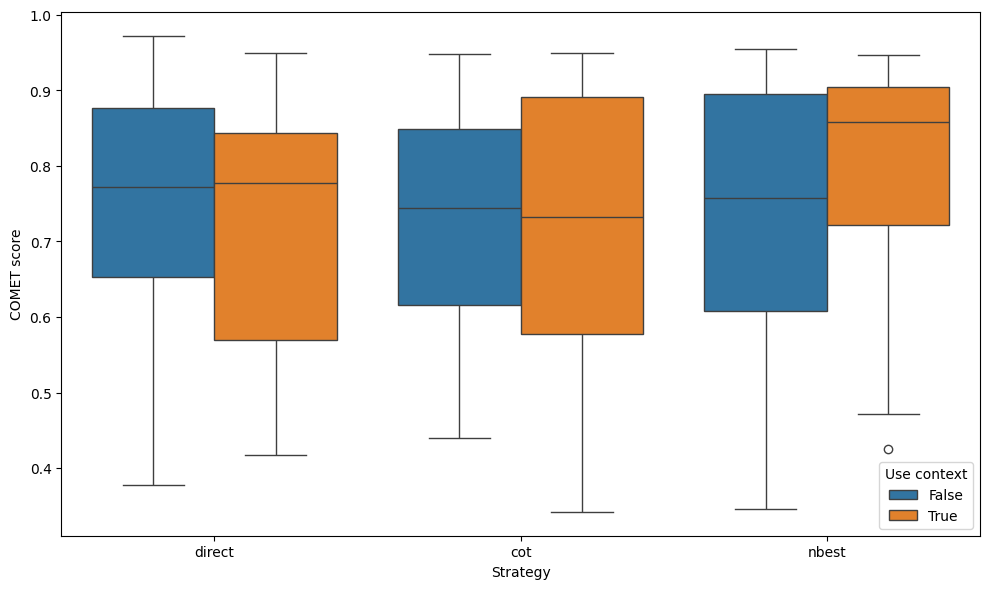

In [147]:
#| echo: false
#| fig-cap: "COMET score distribution by strategy and context"
#| label: fig:comet_boxplot


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.boxplot(
    data=res_all_models_pivot,
    x="strategy",
    y="comet_score",
    hue="use_context",
)

plt.ylabel("COMET score")
plt.xlabel("Strategy")
plt.legend(title="Use context")

plt.tight_layout()
plt.show()

Looking at the results separated by model in Figure 2, we can see that mistral has overall better scores than llama3.2, but llama3.2 seems to benefit more from context in the $n$-best strategy.

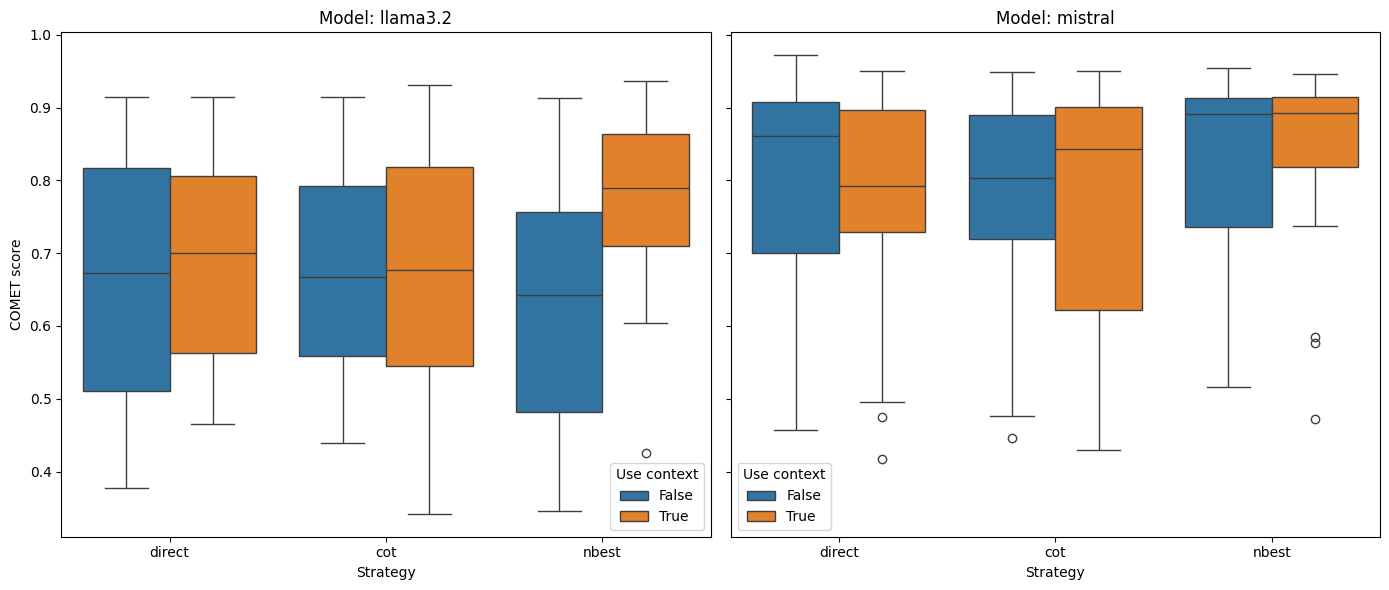

In [153]:
#| echo: false
#| fig-cap: "COMET score distribution by strategy and context, separated by model"
#| label: fig:comet_boxplot_by_model

import seaborn as sns
import matplotlib.pyplot as plt

models = res_all_models_pivot["model"].unique()

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(models),
    figsize=(14, 6),
    sharey=True,
)

for ax, model_name in zip(axes, models):
    model_df = res_all_models_pivot[
        res_all_models_pivot["model"] == model_name
    ]

    sns.boxplot(
        data=model_df,
        x="strategy",
        y="comet_score",
        hue="use_context",
        ax=ax,
    )

    ax.set_title(f"Model: {model_name}")
    ax.set_xlabel("Strategy")
    ax.set_ylabel("COMET score")

    ax.legend(title="Use context")

plt.tight_layout()
plt.show()

### Improvement over direct translation

We can also compute the deltas to see the improvements over direct translation.

In [ ]:
#| echo: false

res_all_models["cot_delta"] = res_all_models["cot_comet"] - res_all_models["direct_comet"]
res_all_models["nbest_delta"] = (res_all_models["nbest_best_score"] - res_all_models["direct_comet"])

We prefer to plot violin plots here to see the distribution of improvements. Confirming our previous observations, only the $n$-best strategy with context consistently improves over direct translation for both models, but here we can see that this improvement is very subtle, as most of the distribution is concentrated around 0. The distribution of the $n$-best with context is skewed towards positive improvements, especially the lower values, and this explains the higher median we observed earlier.

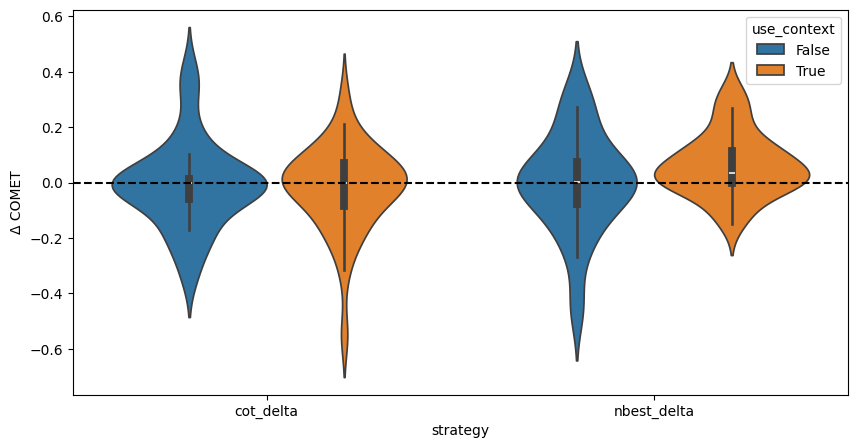

In [149]:
#| echo: false
#| fig-cap: "Improvement over direct translation (COMET)"
#| label: fig:comet_delta_violinplot

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.violinplot(
    data=res_all_models.melt(
        id_vars=["model", "use_context"],
        value_vars=["cot_delta", "nbest_delta"],
        var_name="strategy",
        value_name="delta",
    ),
    x="strategy",
    y="delta",
    hue="use_context",
)
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("Δ COMET")
plt.show()

When looking at the improvement by model, Llama3.2's distribution is more spread out compared to mistral. Without context, Llama3.2 has difficulty producing good candidates for the $n$-best strategy, as we cans see from the important part of the distribution having negative deltas. Adding context helps a lot here, as the distribution shifts towards more positive values. Mistral seems to perform better overall, and as such the boost from context is less pronounced, although still visible.

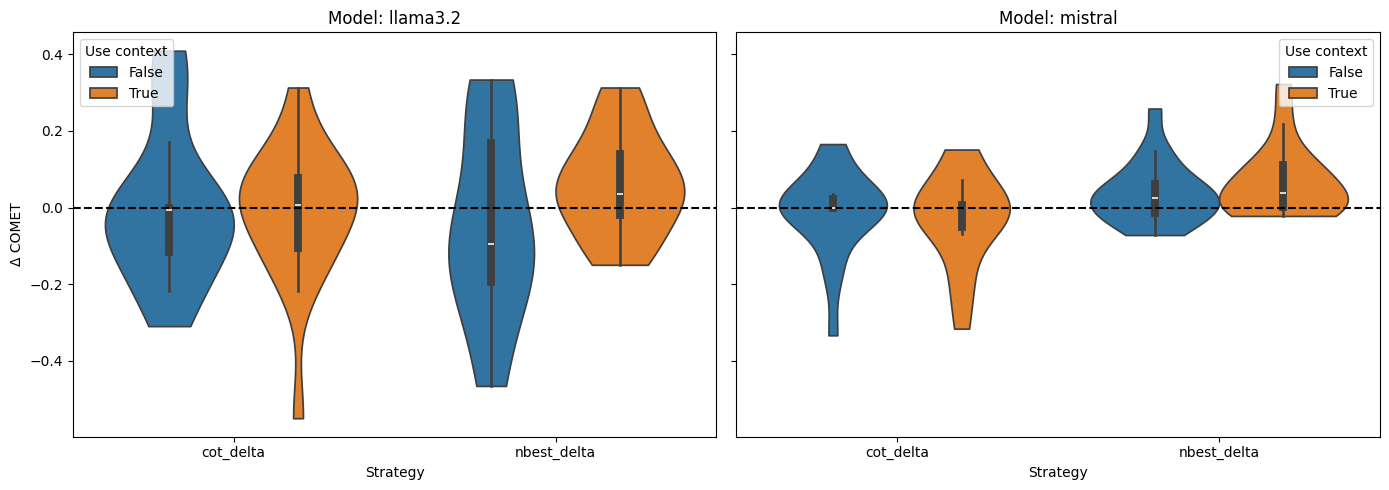

In [150]:
#| echo: false
#| fig-cap: "Improvement over direct translation (COMET), separated by model"
#| label: fig:comet_delta_violinplot_by_model

import seaborn as sns
import matplotlib.pyplot as plt

# Reshape once
delta_df = res_all_models.melt(
    id_vars=["model", "use_context"],
    value_vars=["cot_delta", "nbest_delta"],
    var_name="strategy",
    value_name="delta",
)

models = delta_df["model"].unique()

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(models),
    figsize=(14, 5),
    sharey=True,
)

for ax, model_name in zip(axes, models):
    model_df = delta_df[delta_df["model"] == model_name]

    sns.violinplot(
        data=model_df,
        x="strategy",
        y="delta",
        hue="use_context",
        ax=ax,
        cut=0,
    )

    ax.axhline(0, color="black", linestyle="--")
    ax.set_title(f"Model: {model_name}")
    ax.set_xlabel("Strategy")
    ax.set_ylabel("Δ COMET")

    ax.legend(title="Use context")

plt.tight_layout()
plt.show()

Finally, we can plot the scatter plots of direct vs COT and $n$-best COMET scores for a more detailed look at the correlations. From the distribution of the data points on the COT plot, it is clear that there is little to no improvement over direct translation. Focusing on the $n$-best with context plot, we can discern that mistral's data points are slightly more concentrated above the diagonal line compared to llama3.2. We also notice that llama3.2 datapoints for the with-context examples (marked with an ex) shift to the right above the diagonal. Again, these two observations are consistent with what we saw earlier, mistral is overall better but benefits less from context.

Given the small deltas in the previous plots, and the poor performance of COT overall, we can conclude that direct translation remains an effective approach for these models. The only reliable way to improve over direct translation is to use $n$-best generation with context, but the improvement remains very subtle.

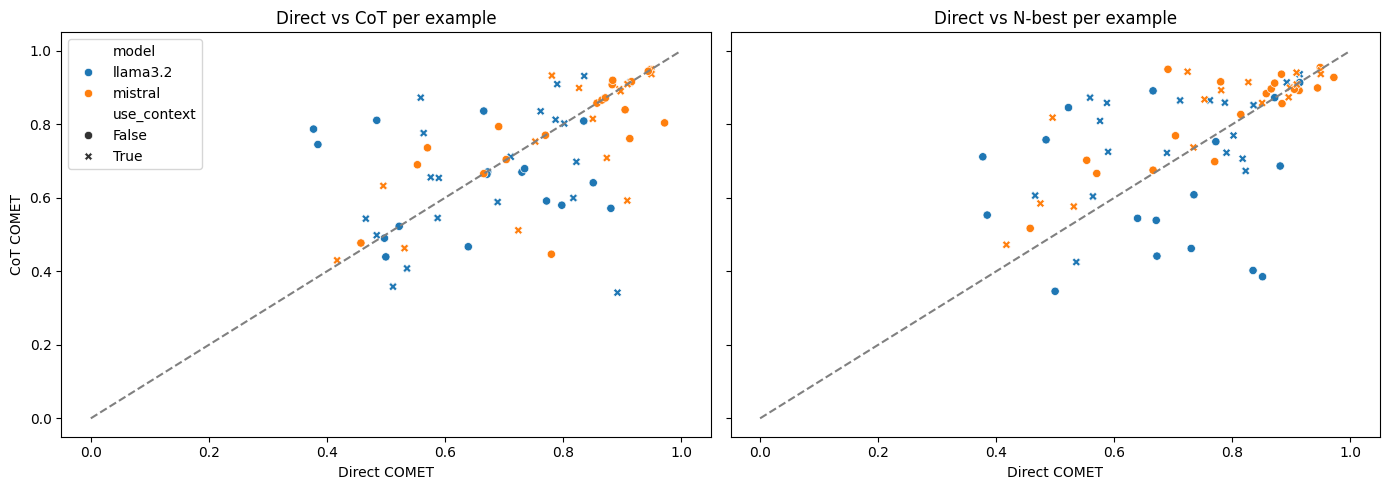

In [151]:
#| echo: false
#| fig-cap: "Direct vs CoT and N-best COMET scores per example"
#| label: fig:comet_scatterplots

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(14, 5),
    sharex=True,
    sharey=True,
)

# Direct vs CoT
sns.scatterplot(
    data=res_all_models,
    x="direct_comet",
    y="cot_comet",
    hue="model",
    style="use_context",
    ax=axes[0],
)

axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_xlabel("Direct COMET")
axes[0].set_ylabel("CoT COMET")
axes[0].set_title("Direct vs CoT per example")

# Direct vs N-best
sns.scatterplot(
    data=res_all_models,
    x="direct_comet",
    y="nbest_best_score",
    hue="model",
    style="use_context",
    ax=axes[1],
)

axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[1].set_xlabel("Direct COMET")
axes[1].set_ylabel("N-best COMET")
axes[1].set_title("Direct vs N-best per example")

# Remove duplicate legends
axes[1].legend_.remove()

plt.tight_layout()
plt.show()